## Super resolution
https://www.fast.ai/2019/05/03/decrappify/

What we have done here is pretty much just step 1 of the NoGAN training mentioned in the article.

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

I have only included the highres-2000 folder in Mega, the rest have to be generated yourself. You can use the code in the subsequent cells.

In [2]:
#Change this to where your images are
path = Path('/home/jupyter/Nepal')
path_hr= path/'highres-2000'

#its fine to define a path to something that doesn't exist
path_cropped_130 = path/'cropped-130'
path_cropped_130_nearest = path/'cropped-130-nearest'
path_cropped_600= path/'cropped-600'



In [3]:
il = ImageList.from_folder(path_hr)

Since I already cropped the images, we can omit cropping and only resize them.

In [5]:
#where to crop. (xtop,ytop,xbottom,ybottom)
box = (920,0,2900,2000)
def crop_and_resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
#     img = img.crop(box)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest)

In [6]:
# # Crop and resize high res images into a designated directory
# sets = [(path_cropped_130, 130),(path_cropped_600, 600)]
# for p,size in sets:
#     if not p.exists(): 
#         print(f"resizing to {size} into {p}")
#         parallel(partial(crop_and_resize_one, path=p, size=size), il.items)

resizing to 2000 into ../../../../Nepal/highres-2000


In [10]:
def visualize_img_file(path):
    img = PIL.Image.open(path)
    _,ax = plt.subplots(1,1,figsize=(20,20))
    ax.imshow(img)


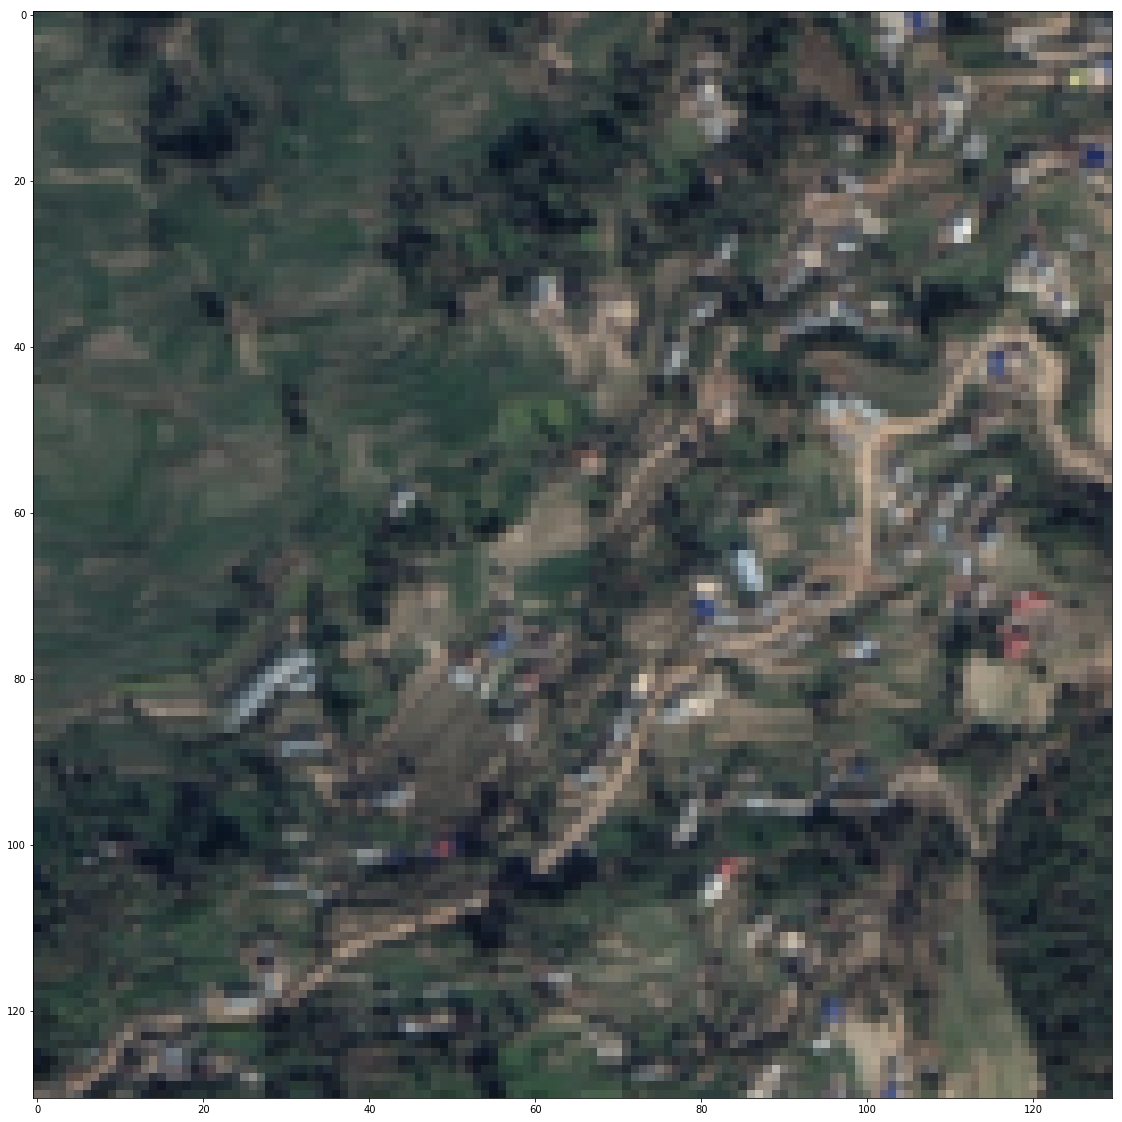

In [13]:
visualize_img_file(path_cropped_130.ls()[0])

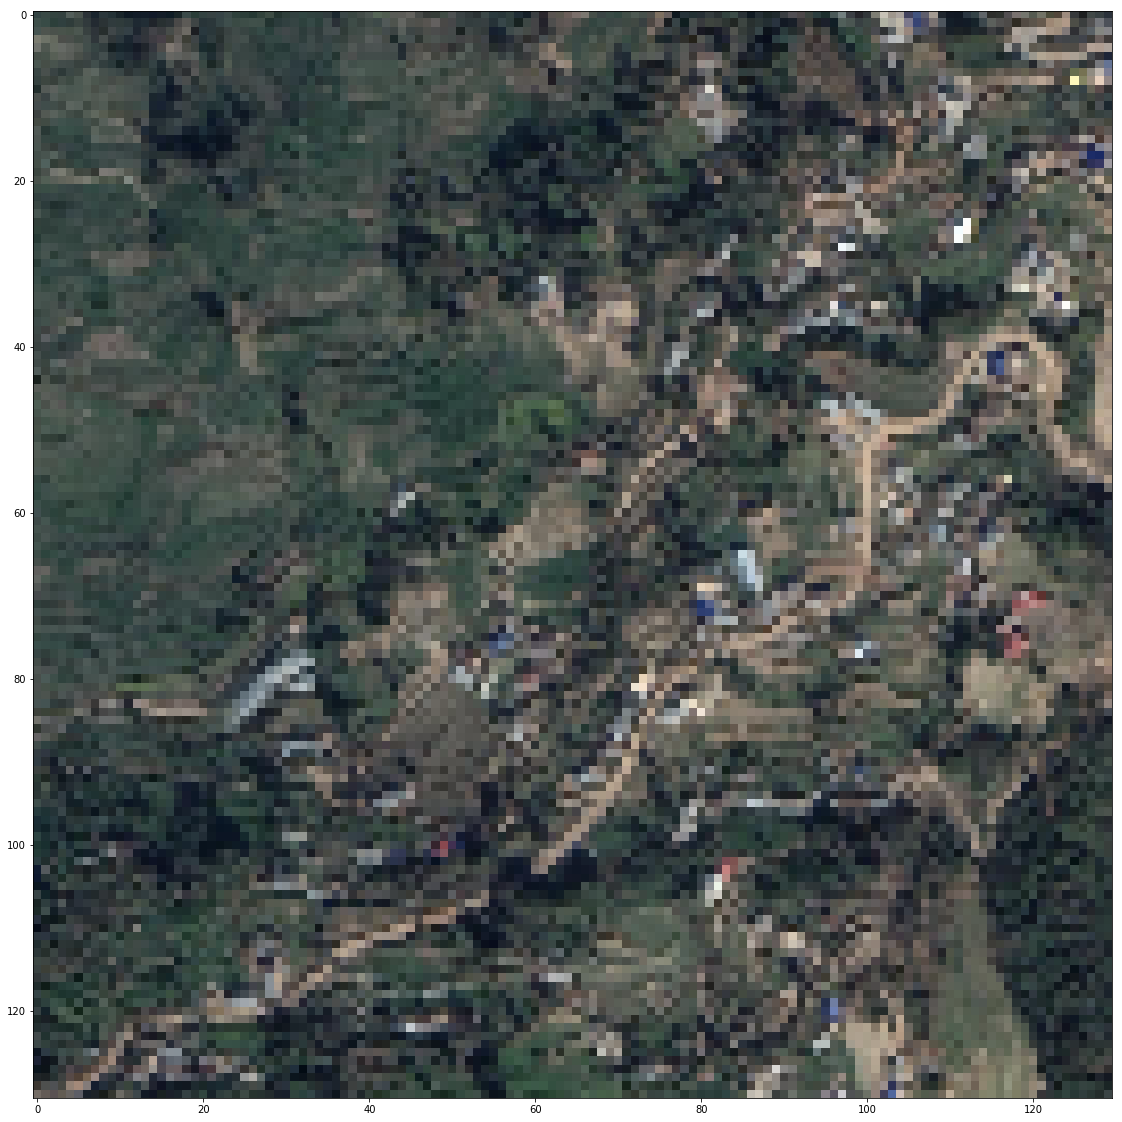

In [14]:
visualize_img_file(path_cropped_130_nearest.ls()[0])

Take note of the PATH fed into the ImageImageList. Calls to learn.save() will result in model weights being saved in `PATH/models` and calls to learn.export() will result in an `export.pkl` file being saved in the PATH. Further instructions on how  `export.pkl` can be used is in the inference notebook.

In [12]:
bs,size=7,300

#Architecture to use in the Unet backbone
arch = models.resnet34

#Change the path to the path of the input images
src = ImageImageList.from_folder(path_cropped_130).split_by_rand_pct(0.1, seed=42)

In [13]:
# Change the path in label_from_func to the path where 
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_cropped_600/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [14]:
data = get_data(bs,size)

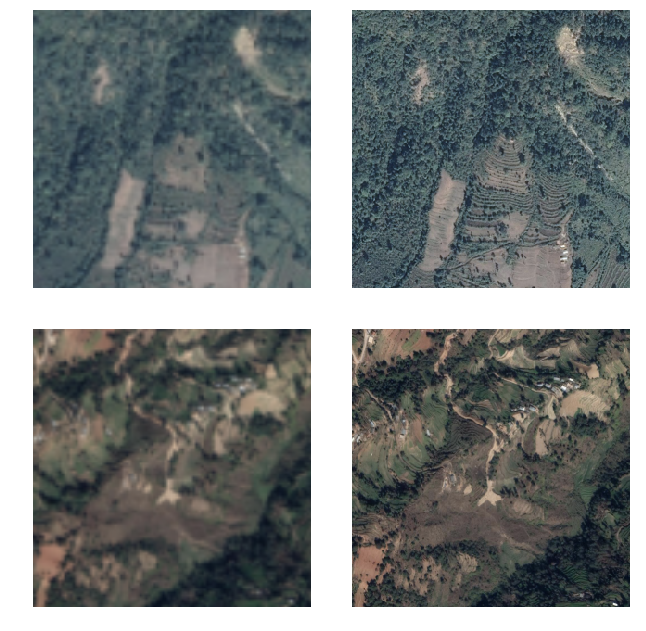

In [15]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

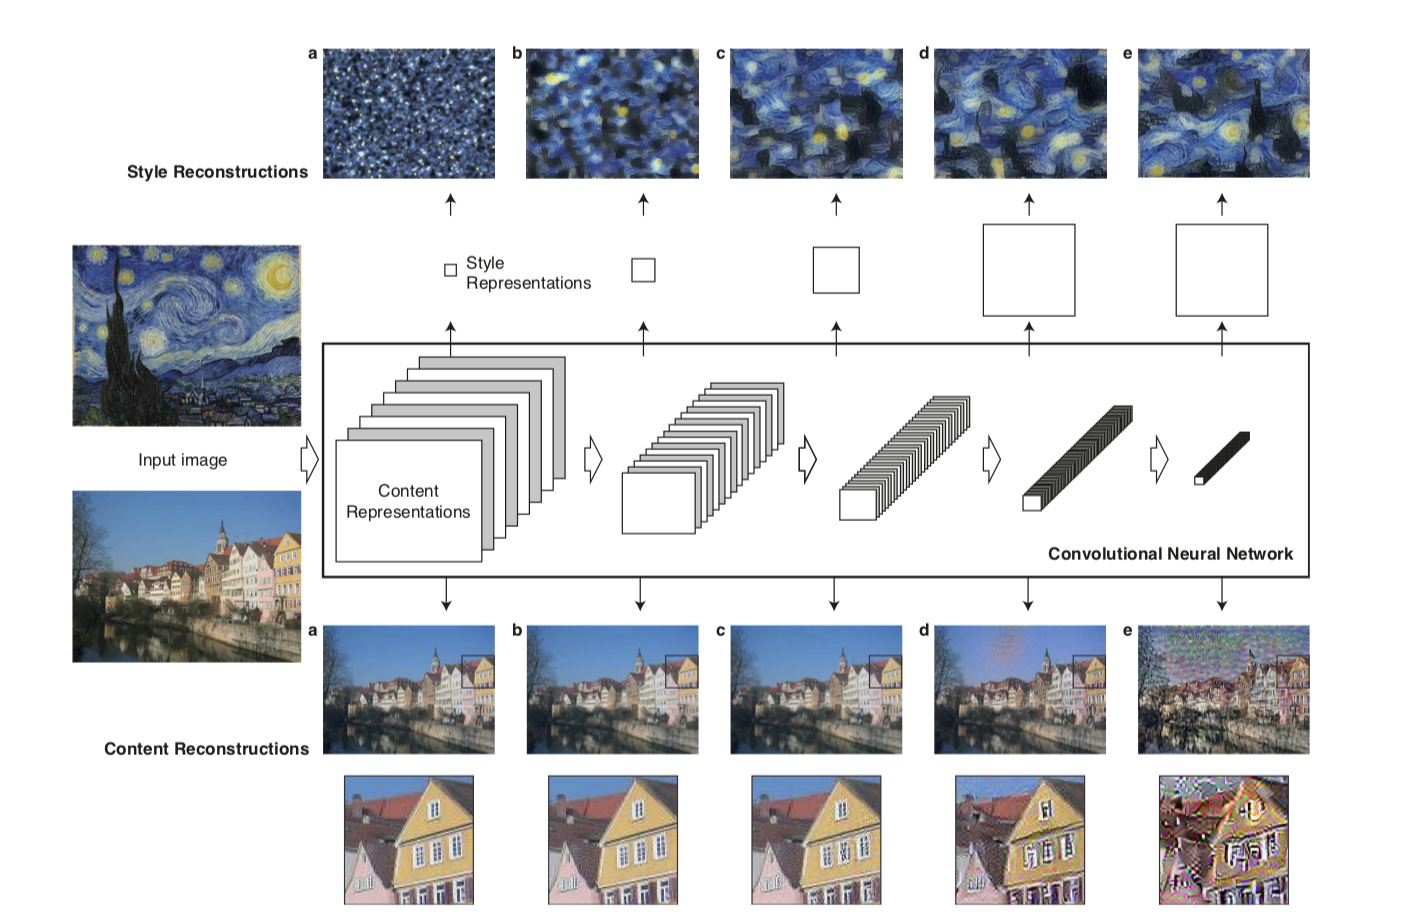
For more info, refer to http://openaccess.thecvf.com/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

In [17]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [18]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [19]:
gram_matrix(t)

tensor([[[0.0405, 0.0455, 0.0463],
         [0.0455, 0.0517, 0.0528],
         [0.0463, 0.0528, 0.0542]],

        [[0.0405, 0.0455, 0.0463],
         [0.0455, 0.0517, 0.0528],
         [0.0463, 0.0528, 0.0542]]])

In [20]:
base_loss = F.l1_loss

In [21]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [22]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [23]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [24]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [25]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


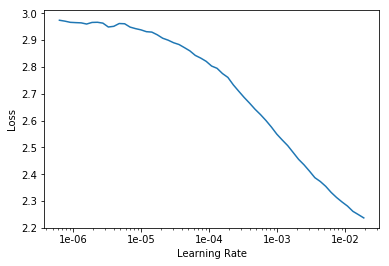

In [26]:
learn.lr_find()
learn.recorder.plot()

In [33]:
lr = 1e-3

# Training and Saving
Note that this saves the model after training for 10 epochs.

In [34]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

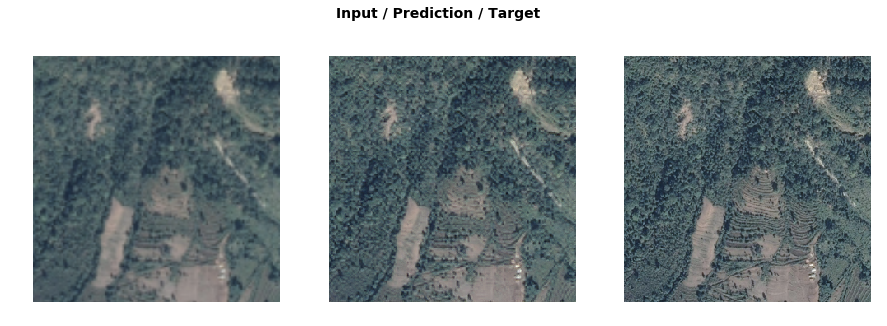

In [35]:
do_fit('1a_v2', slice(lr*10))

In [36]:
learn.unfreeze()

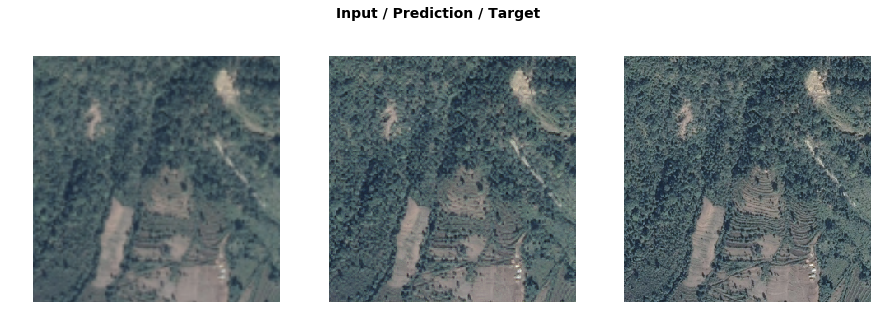

In [37]:
do_fit('1b_v2', slice(1e-5,lr))

In [38]:
data = get_data(2,size*2)

In [39]:
learn.data = data
learn.freeze()
gc.collect()

17987

In [34]:
learn.load('1b_v2');

/home/jupyter/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


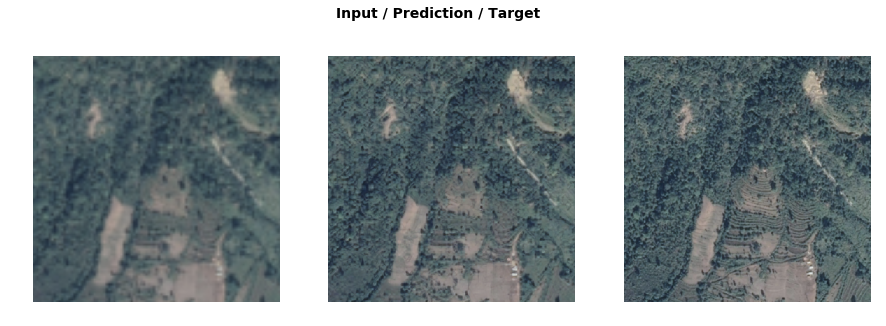

In [35]:
do_fit('2a_v2')

In [23]:
learn.load('2a_v2');

/home/jupyter/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [24]:
learn.unfreeze()

In [ ]:
do_fit('2b_v2', slice(1e-6,1e-4), pct_start=0.3)

# Test

In [16]:
learn = None
gc.collect();

In [17]:
size = (500,500)

In [18]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [20]:
data_mr = (ImageImageList.from_folder(path/'cropped-600').split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [21]:
learn.load('2a');

In [22]:
# Exports a pkl file to the path designed in the data object fed to the learner
# learn.export()

In [24]:
learn.data = data_mr

Test it out on your own images.

In [25]:
img = open_image('01157.tif'); img.shape

torch.Size([3, 1002, 1130])

In [26]:
p,img_hr,b = learn.predict(img)

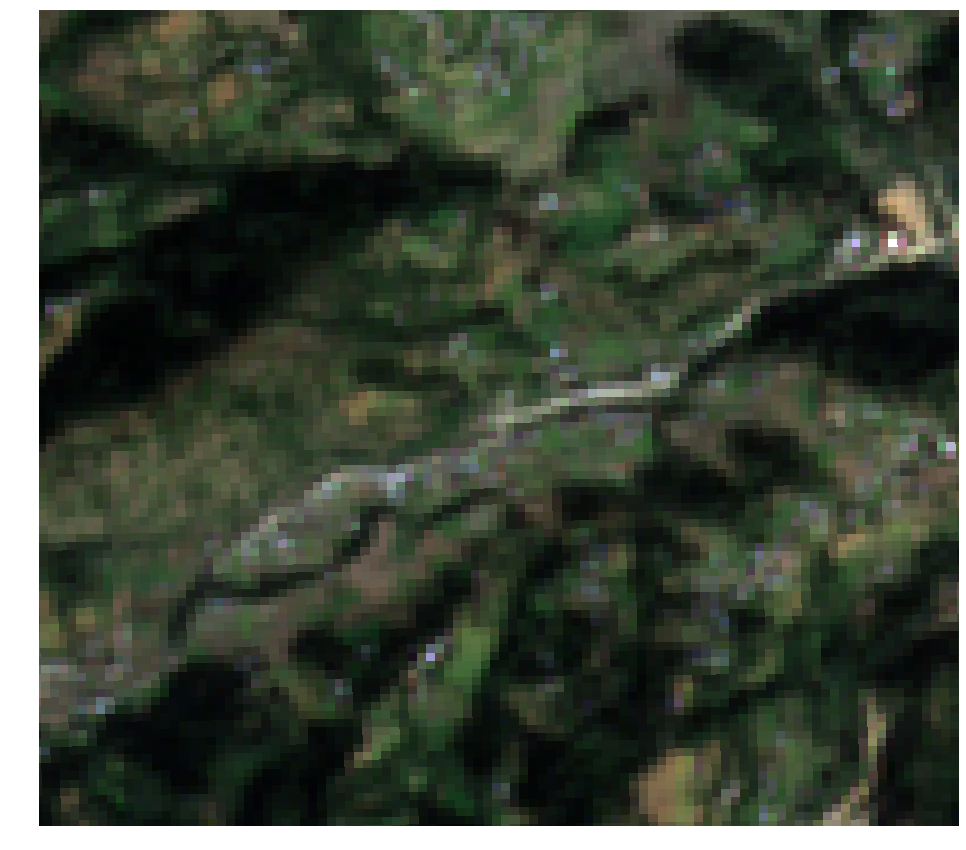

In [27]:
#Original
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


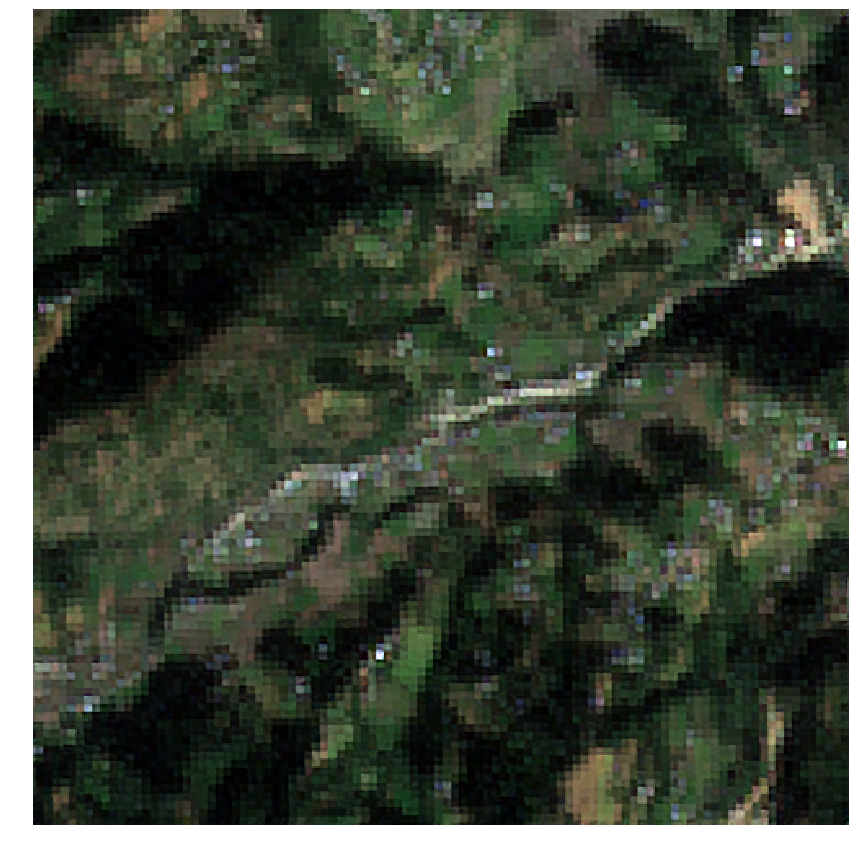

In [28]:
#Superres
Image(img_hr).show(figsize=(18,15))

In [30]:
img = open_image('test_scale_1-2_sr.jpg'); img.shape

torch.Size([3, 480, 544])

In [31]:
p,img_hr,b = learn.predict(img)

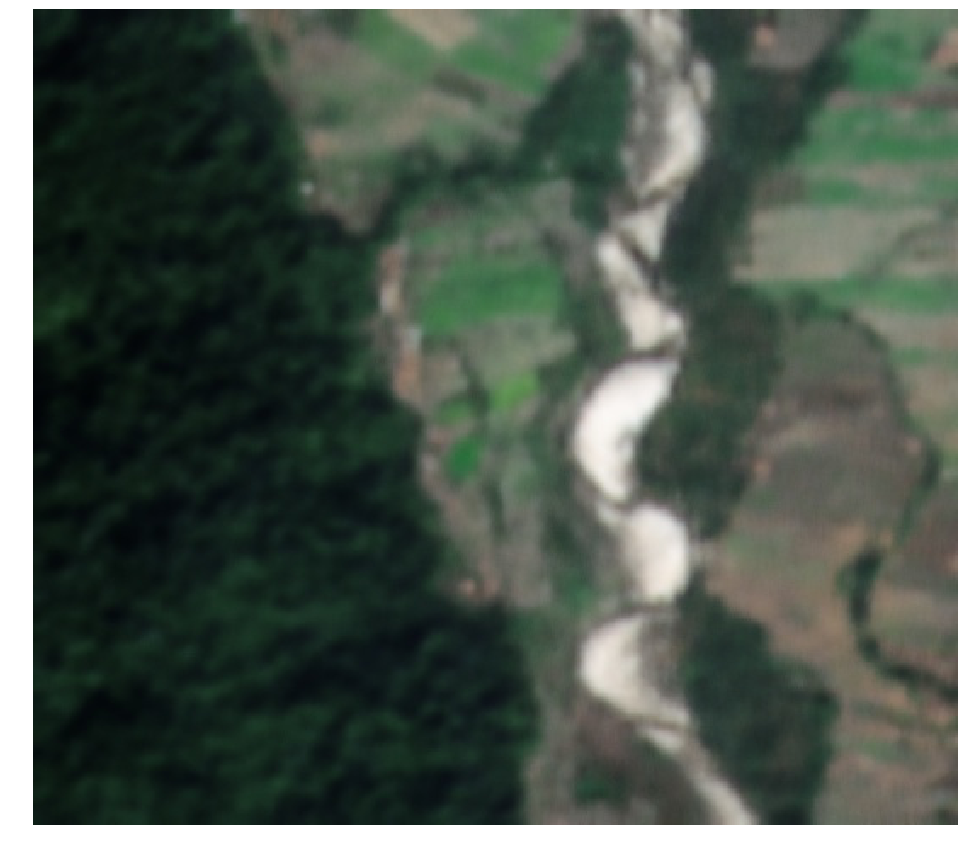

In [32]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


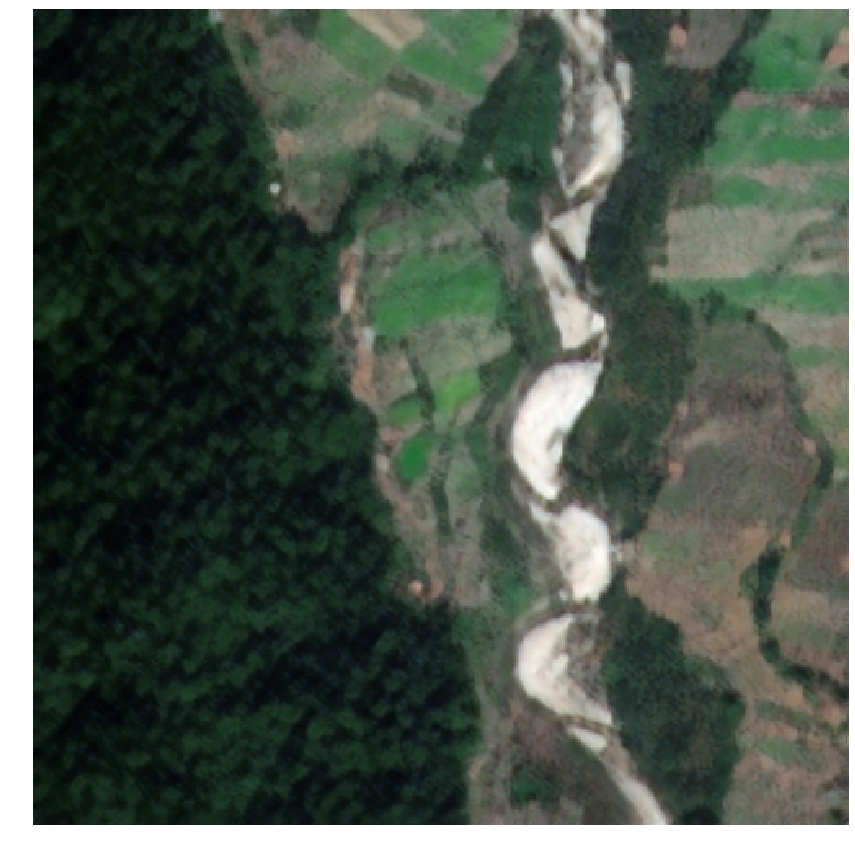

In [33]:
Image(img_hr).show(figsize=(18,15))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


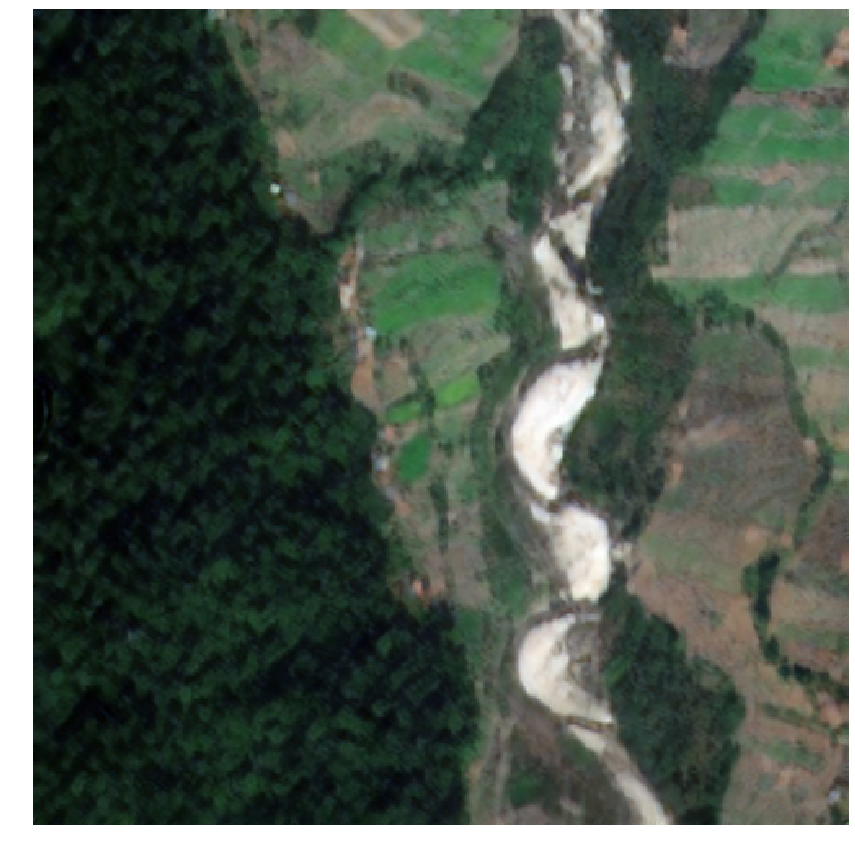

In [35]:
img = open_image('test_scale_1-2_sr_3k-iters.jpg'); img.shape
p,img_hr,b = learn.predict(img)
Image(img_hr).show(figsize=(18,15))